# Imports

In [1]:
PROJECT_DIR = "/Users/pluz999/Documents/Oxford/Thesis/queue-value"

import sys
sys.path.append(PROJECT_DIR)

import matplotlib
import os

from datetime import datetime, time, timedelta
from collections import defaultdict
import pylab as pl
from tqdm import tqdm
from typing import Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.sparse import csc_matrix, identity, linalg

from definitions import ROOT_DIR
from micro_price.ImbalanceMicroPrice import ImbalanceMicroPrice
from order_value.ImbalanceQueueOrderValue import ImbalanceQueueOrderValue
from orderbook_aggregator.ImbalanceQueueAggregator import ImbalanceQueueAggregator

# Set font

In [2]:
matplotlib.rc('font', family='Times New Roman') 
matplotlib.rc('text', usetex='false') 
matplotlib.rcParams.update({'font.size': 12})

# Global variables

In [3]:
csco_ticker = "CSCO"
csco_levels = 5
csco_start_date = datetime(2019,1,1)
csco_end_date = datetime(2019,1,31)

bac_ticker = "BAC"
bac_levels = 10
bac_start_date = datetime(2019,11,1)
bac_end_date = datetime(2019,11,27)

# Load and process order book data

In [4]:
csco_orderbooks: List[ImbalanceQueueAggregator] = []
for d in tqdm(pd.date_range(csco_start_date, csco_end_date)):
    try:
        csco_orderbooks.append(ImbalanceQueueAggregator(d, csco_ticker, csco_levels, spread_size=100))
    except FileNotFoundError:
        continue

100%|██████████| 31/31 [39:00<00:00, 75.49s/it]  


In [5]:
bac_orderbooks: List[ImbalanceQueueAggregator] = []
for d in tqdm(pd.date_range(bac_start_date, bac_end_date)):
    try:
        bac_orderbooks.append(
            ImbalanceQueueAggregator(
                d, bac_ticker, bac_levels, spread_size=100, queue_position_step_size=2_000, max_queue_position = 20_000
            )
        )
    except FileNotFoundError:
        continue

100%|██████████| 27/27 [16:14<00:00, 36.10s/it]


# Order book analysis

In [6]:
h_score_df = bac_orderbooks[0].raw_orderbook.copy()
limit_sell_h_score = h_score_df[h_score_df["event_type"] == 1][h_score_df["direction"] == -1]["size"]
market_buy_h_score = h_score_df[
    [t in [4, 5] for t in h_score_df["event_type"]]
][h_score_df["direction"] == 1]["size"]
cancel_sell_h_score = h_score_df[
    [t in [2, 3] for t in h_score_df["event_type"]]
][h_score_df["direction"] == -1]["size"]

<ipython-input-6-af2e3250b8d9>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  limit_sell_h_score = h_score_df[h_score_df["event_type"] == 1][h_score_df["direction"] == -1]["size"]
<ipython-input-6-af2e3250b8d9>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  market_buy_h_score = h_score_df[
<ipython-input-6-af2e3250b8d9>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cancel_sell_h_score = h_score_df[


/Users/pluz999/Documents/Oxford/Thesis/env/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/pluz999/Documents/Oxford/Thesis/env/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


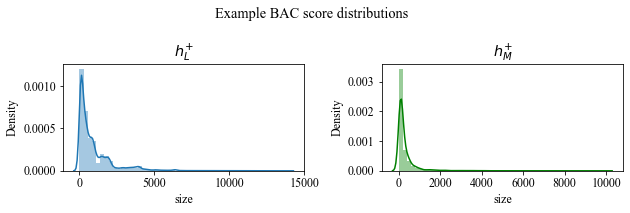

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(9,3))

sns.distplot(limit_sell_h_score, ax=ax[0])
ax[0].set_title(r"$h^{+}_{L}$")
sns.distplot(market_buy_h_score, ax=ax[1], color="g")
ax[1].set_title(r"$h^{+}_{M}$")

fig.suptitle("Example BAC score distributions")
fig.tight_layout()

plt.show()

In [8]:
bac_orderbooks[0].orderbook.head().drop(
    columns=["next_imbalance", "prev_mid_move", "next_spread", "limit_buy", "limit_sell"]
)

,ask_price_0,ask_size_0,bid_price_0,bid_size_0,imbalance,spread,mid_price,mid_price_move,cancel_buy,cancel_sell,market_buy,market_sell
datetime,,,,,,,,,,,,
2019-11-01 09:45:01.300,313900,800,313800,4509,0.8,100,313850.0,0.0,0.0,100.0,0.0,0.0
2019-11-01 09:45:01.400,313900,700,313800,4509,0.9,100,313850.0,0.0,300.0,0.0,0.0,0.0
2019-11-01 09:45:01.500,313900,900,313800,4409,0.8,100,313850.0,0.0,0.0,0.0,0.0,0.0
2019-11-01 09:45:01.600,313900,900,313800,4409,0.8,100,313850.0,0.0,400.0,4200.0,0.0,0.0
2019-11-01 09:45:01.700,313900,900,313800,4109,0.8,100,313850.0,0.0,0.0,400.0,0.0,0.0


In [9]:
non_clipped_orderbook = (
    bac_orderbooks[0].raw_orderbook.copy().drop_duplicates(["datetime"], keep="last").set_index("datetime")
)
non_clipped_orderbook = non_clipped_orderbook.reindex(bac_orderbooks[0].time_steps(), method="ffill")
non_clipped_orderbook["mid_price_move"] = (
    non_clipped_orderbook["mid_price"].shift(-1) - non_clipped_orderbook["mid_price"]
)

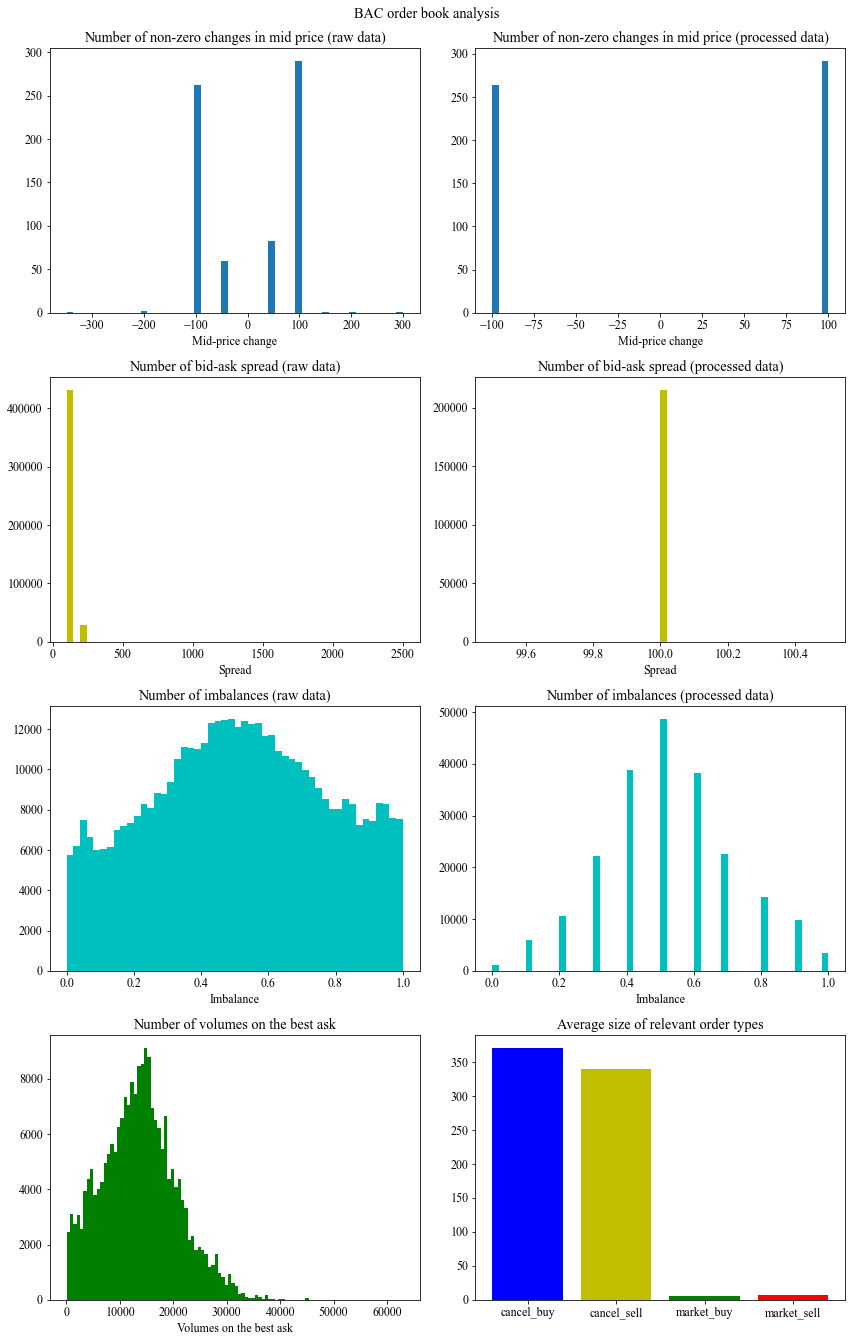

In [10]:
fig, ax = plt.subplots(4,2, figsize=(12,19))

ax[0,0].hist(non_clipped_orderbook[non_clipped_orderbook["mid_price_move"] != 0]["mid_price_move"] , bins=50)
ax[0,0].set_title("Number of non-zero changes in mid price (raw data)")
ax[0,0].set_xlabel("Mid-price change")

ax[0,1].hist(
    bac_orderbooks[0].orderbook[bac_orderbooks[0].orderbook["mid_price_move"] != 0]["mid_price_move"], bins=50
)
ax[0,1].set_title("Number of non-zero changes in mid price (processed data)")
ax[0,1].set_xlabel("Mid-price change")

ax[1,0].hist(bac_orderbooks[0].raw_orderbook["spread"], bins=50, color="y")
ax[1,0].set_title("Number of bid-ask spread (raw data)")
ax[1,0].set_xlabel("Spread")

ax[1,1].hist(bac_orderbooks[0].orderbook["spread"], bins=50, color="y")
ax[1,1].set_title("Number of bid-ask spread (processed data)")
ax[1,1].set_xlabel("Spread")

ax[2,0].hist(bac_orderbooks[0].raw_orderbook["imbalance"], bins=50, color="c")
ax[2,0].set_title("Number of imbalances (raw data)")
ax[2,0].set_xlabel("Imbalance")

ax[2,1].hist(bac_orderbooks[0].orderbook["imbalance"], bins=50, color="c")
ax[2,1].set_title("Number of imbalances (processed data)")
ax[2,1].set_xlabel("Imbalance")

ax[3,0].hist(bac_orderbooks[0].orderbook["ask_size_0"], bins=100, color="g")
ax[3,0].set_title("Number of volumes on the best ask")
ax[3,0].set_xlabel("Volumes on the best ask")

my_colors = ['b', 'y', 'g', 'r']
ax[3,1].bar(
    ["cancel_buy", "cancel_sell", "market_buy", "market_sell"],
    (
        bac_orderbooks[0].orderbook[["cancel_buy", "cancel_sell", "market_buy", "market_sell"]].sum() / 
        len(bac_orderbooks[0].orderbook)
    ), 
    color=my_colors
)
ax[3,1].set_title("Average size of relevant order types")

fig.suptitle("BAC order book analysis")
fig.tight_layout()
fig.subplots_adjust(top=0.95)

plt.show()

# Queue value analysis

### Import micro-price

In [11]:
csco_microprices = pd.read_csv(
    os.path.join(ROOT_DIR, "models", "csco_imbalance_micro_price.csv"), index_col=[0]
).values.T[0]

bac_microprices = pd.read_csv(
    os.path.join(ROOT_DIR, "models", "bac_imbalance_micro_price.csv"), index_col=[0]
).values.T[0]

### Determine Markov chain probabilities

In [12]:
csco_queue_value = ImbalanceQueueOrderValue(csco_orderbooks, csco_microprices)

100%|██████████| 20/20 [1:46:36<00:00, 319.82s/it]


In [13]:
bac_queue_value = ImbalanceQueueOrderValue(bac_orderbooks, bac_microprices)

100%|██████████| 19/19 [1:42:53<00:00, 324.90s/it]


### Plot $\delta$'s

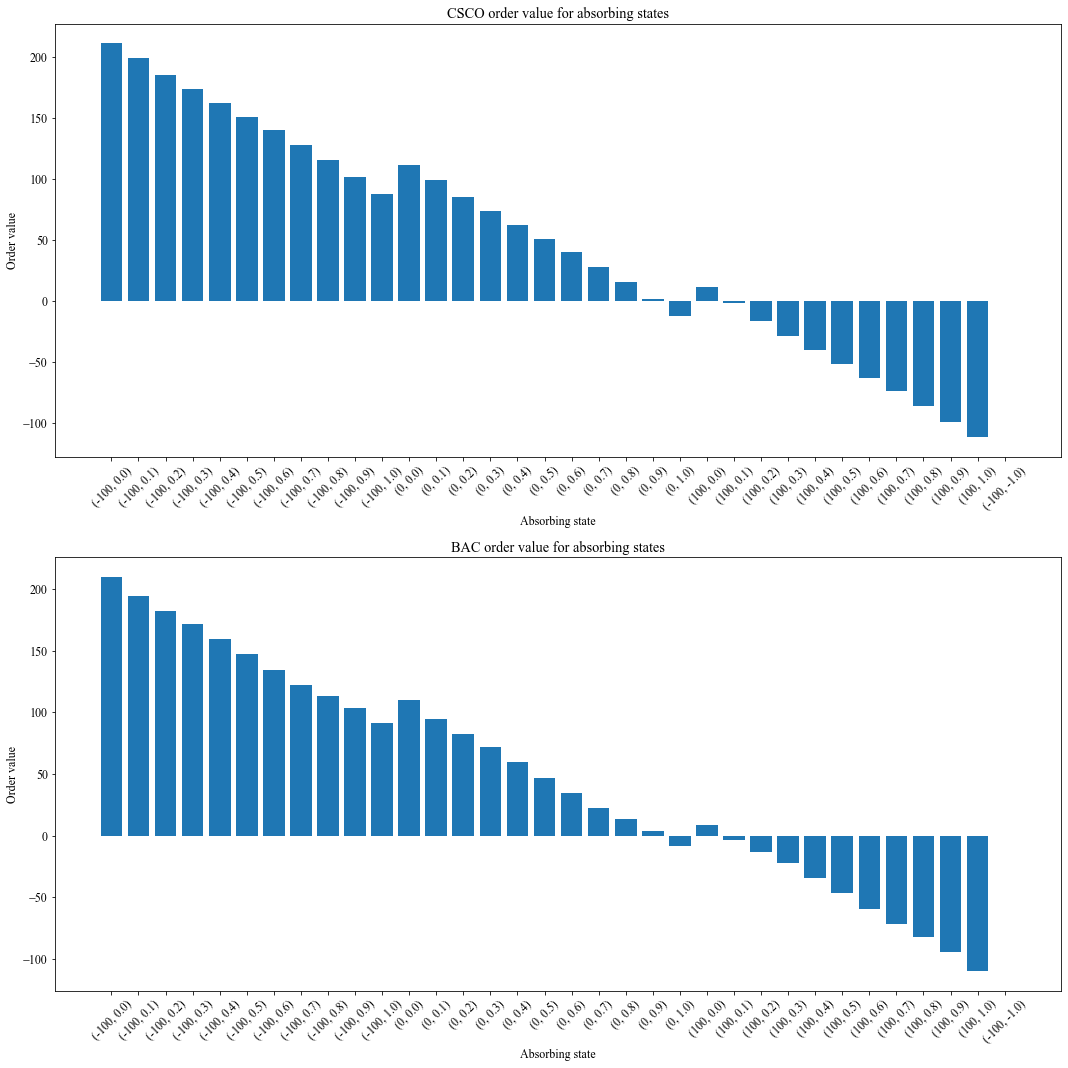

In [14]:
fig, ax = plt.subplots(2, 1, figsize=(15,15))

ax[0].bar(
    [str((x[0], x[1])) for x in csco_queue_value.absorbing_prob_df.columns.values], 
    csco_queue_value.final_state_values
)
ax[0].set_title("CSCO order value for absorbing states")
ax[0].set_xlabel("Absorbing state")
ax[0].set_ylabel("Order value")

ax[1].bar(
    [str((x[0], x[1])) for x in bac_queue_value.absorbing_prob_df.columns.values], 
    bac_queue_value.final_state_values
)
ax[1].set_title("BAC order value for absorbing states")
ax[1].set_xlabel("Absorbing state")
ax[1].set_ylabel("Order value")

ax[0].tick_params(axis='x', rotation=45)
ax[1].tick_params(axis='x', rotation=45)

fig.tight_layout()

plt.show()

### Investigate probabilities of state moves

In [15]:
csco_transient_sum = (
    identity(len(csco_queue_value.transient_prob_df.columns)).todense() - 
    csco_queue_value.transient_prob_df.values
)
csco_inv_trans_sum = pd.DataFrame(
    index=csco_queue_value.transient_prob_df.index,
    columns=csco_queue_value.transient_prob_df.columns,
    data=np.linalg.inv(csco_transient_sum)
).round(3)
csco_abs_delta_product = np.dot(csco_queue_value.absorbing_prob_df.values, csco_queue_value.final_state_values)

bac_transient_sum = (
    identity(len(bac_queue_value.transient_prob_df.columns)).todense() - 
    bac_queue_value.transient_prob_df.values
)
bac_inv_trans_sum = pd.DataFrame(
    index=bac_queue_value.transient_prob_df.index,
    columns=bac_queue_value.transient_prob_df.columns,
    data=np.linalg.inv(bac_transient_sum)
).round(3)
bac_abs_delta_product = np.dot(bac_queue_value.absorbing_prob_df.values, bac_queue_value.final_state_values)

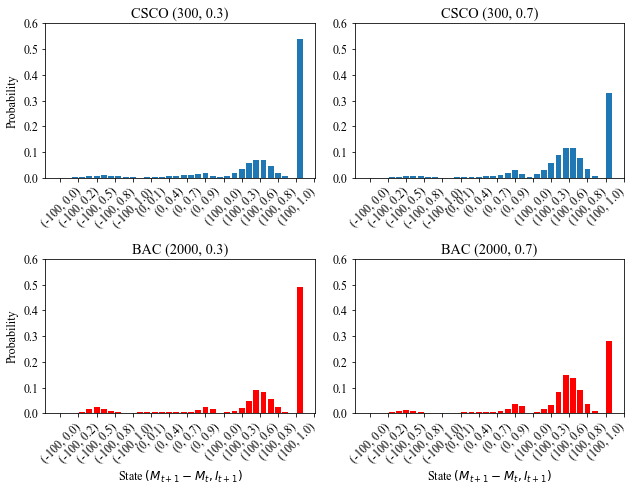

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(9,7))

ax[0, 0].bar(
    [str((x[0], x[1])) for x in csco_queue_value.absorbing_prob_df.columns.values], 
    np.dot(csco_inv_trans_sum.iloc[30].values, csco_queue_value.absorbing_prob_df.values)
)
ax[0, 0].set_title(
    f"CSCO {csco_inv_trans_sum.iloc[30].name[1:][::-1]}"
)
ax[0, 0].set_ylabel("Probability")
ax[0, 0].xaxis.set_major_locator(plt.MaxNLocator(16))

ax[0, 1].bar(
    [str((x[0], x[1])) for x in csco_queue_value.absorbing_prob_df.columns.values], 
    np.dot(csco_inv_trans_sum.iloc[70].values, csco_queue_value.absorbing_prob_df.values)
)
ax[0, 1].set_title(
    f"CSCO {csco_inv_trans_sum.iloc[70].name[1:][::-1]}"
)
ax[0, 1].xaxis.set_major_locator(plt.MaxNLocator(16))

ax[1, 0].bar(
    [str((x[0], x[1])) for x in bac_queue_value.absorbing_prob_df.columns.values], 
    np.dot(bac_inv_trans_sum.iloc[30].values, bac_queue_value.absorbing_prob_df.values),
    color="r"
)
ax[1, 0].set_title(
    f"BAC {bac_inv_trans_sum.iloc[30].name[1:][::-1]}"
)
ax[1, 0].set_ylabel("Probability")
ax[1, 0].xaxis.set_major_locator(plt.MaxNLocator(16))
ax[1, 0].set_xlabel(r"State $(M_{t+1}-M_{t}, I_{t+1})$")

ax[1, 1].bar(
    [str((x[0], x[1])) for x in bac_queue_value.absorbing_prob_df.columns.values], 
    np.dot(bac_inv_trans_sum.iloc[70].values, bac_queue_value.absorbing_prob_df.values),
    color="r"
)
ax[1, 1].set_title(
    f"BAC {bac_inv_trans_sum.iloc[70].name[1:][::-1]}"
)
ax[1, 1].xaxis.set_major_locator(plt.MaxNLocator(16))
ax[1, 1].set_xlabel(r"State $(M_{t+1}-M_{t}, I_{t+1})$")

plt.setp(ax[0, 0].xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax[0, 1].xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax[1, 0].xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax[1, 1].xaxis.get_majorticklabels(), rotation=45)

ax[0, 0].set_ylim([0, 0.6])
ax[0, 1].set_ylim([0, 0.6])
ax[1, 0].set_ylim([0, 0.6])
ax[1, 1].set_ylim([0, 0.6])

fig.tight_layout()

plt.show()

### Compute order values

In [17]:
csco_order_value_df = csco_queue_value.calculate_order_values()

bac_order_value_df = bac_queue_value.calculate_order_values()

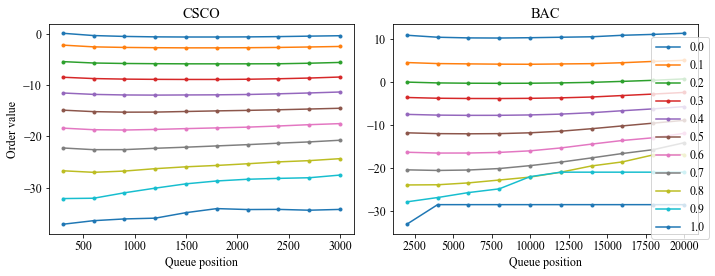

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))

ax[0].plot(csco_order_value_df.replace(to_replace=0, method="ffill"), ".-")
ax[0].set_title("CSCO")
ax[0].set_xlabel("Queue position")
ax[0].set_ylabel("Order value")

ax[1].plot(bac_order_value_df.replace(to_replace=0, method="ffill"), ".-")
ax[1].set_title("BAC")
ax[1].set_xlabel("Queue position")

fig.legend(list(csco_order_value_df.columns), loc="right")
fig.tight_layout()
plt.show()

### Order value breakdown

In [19]:
fill_probs = pd.DataFrame(
    index=bac_inv_trans_sum.index.droplevel(0),
    columns=["prob"]
)
for state in fill_probs.index:
    fill_prob_df = pd.DataFrame(
        columns=[bac_inv_trans_sum.loc[(0.0, state[0], state[1])].name],
        index=[str((x[0], x[1])) for x in bac_queue_value.absorbing_prob_df.columns.values],
        data=np.dot(
            bac_inv_trans_sum.loc[(0.0, state[0], state[1])].values, 
            bac_queue_value.absorbing_prob_df.values
        )
    )
    fill_probs.loc[state] = fill_prob_df.loc[
        [state for state in fill_prob_df.index if eval(state)[0] != -100]
    ].sum().iloc[0]

In [20]:
liquidity_premium = pd.DataFrame(
    index=[str(state[1]) for state in bac_queue_value.absorbing_prob_df.columns.values if state[0]==0], 
    columns=["liquidity_premium"],
    data=[50 - mp for mp in bac_microprices]
)

In [21]:
adverse_selection = -1 * bac_order_value_df.stack().swaplevel().reindex(
    fill_probs.index
).divide(fill_probs["prob"])

for state in adverse_selection.index:
    adverse_selection.loc[state] += liquidity_premium.loc[str(state[0])].values[0]

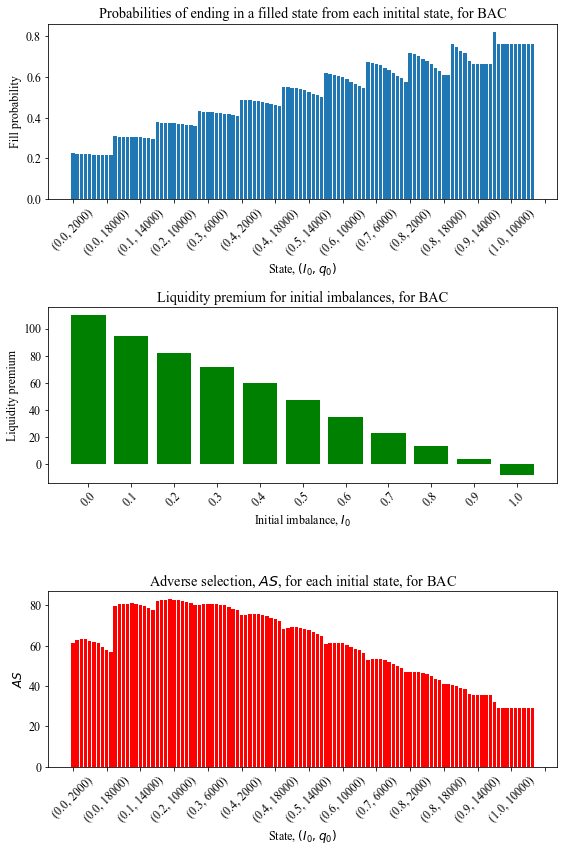

In [22]:
fig, ax = plt.subplots(3, 1, figsize=(8,12))

ax[0].bar(
    [str(state) for state in fill_probs.index], 
    fill_probs.replace(to_replace=0, method="ffill").values.T[0]
)
ax[0].set_title(f"Probabilities of ending in a filled state from each initital state, for BAC")
ax[0].set_xlabel("State, $(I_{0}, q_{0})$")
ax[0].set_ylabel("Fill probability")
ax[0].xaxis.set_major_locator(plt.MaxNLocator(16))

ax[1].bar(
    liquidity_premium.index,
    liquidity_premium["liquidity_premium"],
    color="g"
)
ax[1].set_title("Liquidity premium for initial imbalances, for BAC")
ax[1].set_xlabel("Initial imbalance, $I_{0}$")
ax[1].set_ylabel("Liquidity premium")

ax[2].bar(
    [str(state) for state in adverse_selection.index], 
    adverse_selection.fillna(method="ffill").values,
    color="r"
)
ax[2].set_title("Adverse selection, $AS$, for each initial state, for BAC")
ax[2].set_xlabel("State, $(I_{0}, q_{0})$")
ax[2].set_ylabel(r"$AS$")
ax[2].xaxis.set_major_locator(plt.MaxNLocator(16))

plt.setp(ax[0].xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax[1].xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax[2].xaxis.get_majorticklabels(), rotation=45)

fig.tight_layout()

plt.show()